In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
import os

plt.rcParams.update({
    "figure.figsize": (4.5, 3.5),
    "font.family": "serif",
    "axes.grid": False,
    "savefig.dpi": 300
})

def finalize_plot(filename):
    plt.tight_layout()
    plt.savefig(f"{filename}.pdf")
    plt.show()

# --- Data Download and Load ---
file_id = '1F6b961eijthkGNWuA217IqlzwHM9k_4a'
url = f'https://drive.google.com/uc?id={file_id}'
file_path = 'data.csv'
if not os.path.exists(file_path):
    gdown.download(url, file_path, quiet=False)

df = pd.read_csv(file_path)

# --- Mapping IDs to continuous indices  ---
df['u_index'] = df['userId'].astype('category').cat.codes
df['m_index'] = df['movieId'].astype('category').cat.codes

user_ids = df['u_index'].values
movie_ids = df['m_index'].values
ratings = df['rating'].values

num_users = len(np.unique(user_ids))
num_movies = len(np.unique(movie_ids))

print(f"Practical 4: Environment Ready.")
print(f"Loaded {len(df)} ratings from {num_users} users and {num_movies} movies.")

Downloading...
From (original): https://drive.google.com/uc?id=1F6b961eijthkGNWuA217IqlzwHM9k_4a
From (redirected): https://drive.google.com/uc?id=1F6b961eijthkGNWuA217IqlzwHM9k_4a&confirm=t&uuid=765bd0b5-e178-4ea6-a8e6-d5e6a51f4ddc
To: /content/data.csv
100%|██████████| 877M/877M [00:15<00:00, 56.8MB/s]


Practical 4: Environment Ready.
Loaded 32000204 ratings from 200948 users and 84432 movies.


In [ ]:
# Indexing and Splitting
ratings_by_user = [[] for _ in range(num_users)]
for u, m, r in zip(user_ids, movie_ids, ratings):
    ratings_by_user[u].append((m, r))

train_by_user = [[] for _ in range(num_users)]
train_by_movie = [[] for _ in range(num_movies)]
test_by_user = [[] for _ in range(num_users)]

rng = np.random.default_rng(42)
for u in range(num_users):
    user_ratings = ratings_by_user[u]
    if not user_ratings: continue
    indices = rng.permutation(len(user_ratings))
    cutoff = int(0.8 * len(indices))
    for i in indices[:cutoff]:
        m, r = user_ratings[i]
        train_by_user[u].append((m, r))
        train_by_movie[m].append((u, r))
    for i in indices[cutoff:]:
        m, r = user_ratings[i]
        test_by_user[u].append((m, r))

# Parameters and Initialization
K, epochs = 20, 15
lambda_prec, gamma_reg_bias, gamma_reg_factor = 1.0, 1.0, 1.0
user_biases, item_biases = np.zeros(num_users), np.zeros(num_movies)
user_factors = rng.normal(0, 0.01, (num_users, K))
item_factors = rng.normal(0, 0.01, (num_movies, K))
train_rmse_list, test_rmse_list, loss_list = [], [], []
I = np.eye(K)

print(f"Starting ALS training (K={K})...")
for epoch in range(epochs):
    # Update Users
    for u in range(num_users):
        items = train_by_user[u]
        if not items: continue
        # Bias
        b_sum = sum(lambda_prec * (r - item_biases[i] - user_factors[u] @ item_factors[i]) for i, r in items)
        user_biases[u] = b_sum / (gamma_reg_bias + lambda_prec * len(items))
        # Factors
        A, b = np.zeros((K, K)), np.zeros(K)
        for i, r in items:
            v_i = item_factors[i]
            A += lambda_prec * np.outer(v_i, v_i)
            b += lambda_prec * (r - user_biases[u] - item_biases[i]) * v_i
        user_factors[u] = np.linalg.solve(A + gamma_reg_factor * I, b)

    # Update Items
    for i in range(num_movies):
        users = train_by_movie[i]
        if not users: continue
        # Bias
        b_sum = sum(lambda_prec * (r - user_biases[u] - user_factors[u] @ item_factors[i]) for u, r in users)
        item_biases[i] = b_sum / (gamma_reg_bias + lambda_prec * len(users))
        # Factors
        A, b = np.zeros((K, K)), np.zeros(K)
        for u, r in users:
            u_u = user_factors[u]
            A += lambda_prec * np.outer(u_u, u_u)
            b += lambda_prec * (r - user_biases[u] - item_biases[i]) * u_u
        item_factors[i] = np.linalg.solve(A + gamma_reg_factor * I, b)

    # Metrics
    t_se, t_count = 0, 0
    for u in range(num_users):
        for i, r in train_by_user[u]:
            t_se += (r - (user_biases[u] + item_biases[i] + user_factors[u] @ item_factors[i]))**2
            t_count += 1
    loss = 0.5 * (lambda_prec * t_se + gamma_reg_bias * (np.sum(user_biases**2) + np.sum(item_biases**2)) + gamma_reg_factor * (np.sum(user_factors**2) + np.sum(item_factors**2)))
    loss_list.append(loss)
    train_rmse_list.append(np.sqrt(t_se / t_count))

    v_se, v_count = 0, 0
    for u in range(num_users):
        for i, r in test_by_user[u]:
            v_se += (r - (user_biases[u] + item_biases[i] + user_factors[u] @ item_factors[i]))**2
            v_count += 1
    test_rmse_list.append(np.sqrt(v_se / v_count) if v_count > 0 else 0)
    print(f"Epoch {epoch+1:2d} | Train RMSE: {train_rmse_list[-1]:.4f} | Test RMSE: {test_rmse_list[-1]:.4f}")

Starting ALS training (K=20)...
Epoch  1 | Train RMSE: 0.8181 | Test RMSE: 0.8799
Epoch  2 | Train RMSE: 0.7028 | Test RMSE: 0.8502
Epoch  3 | Train RMSE: 0.6779 | Test RMSE: 0.8297
Epoch  4 | Train RMSE: 0.6657 | Test RMSE: 0.8197
Epoch  5 | Train RMSE: 0.6587 | Test RMSE: 0.8143
Epoch  6 | Train RMSE: 0.6543 | Test RMSE: 0.8112
Epoch  7 | Train RMSE: 0.6512 | Test RMSE: 0.8094
Epoch  8 | Train RMSE: 0.6490 | Test RMSE: 0.8084
Epoch  9 | Train RMSE: 0.6473 | Test RMSE: 0.8079
Epoch 10 | Train RMSE: 0.6461 | Test RMSE: 0.8078
Epoch 11 | Train RMSE: 0.6451 | Test RMSE: 0.8079
Epoch 12 | Train RMSE: 0.6444 | Test RMSE: 0.8081
Epoch 13 | Train RMSE: 0.6437 | Test RMSE: 0.8084
Epoch 14 | Train RMSE: 0.6432 | Test RMSE: 0.8088
Epoch 15 | Train RMSE: 0.6428 | Test RMSE: 0.8092


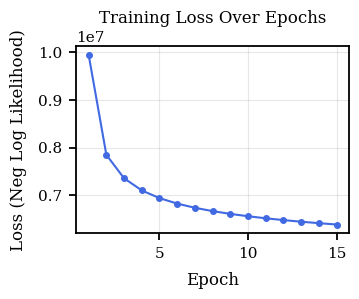

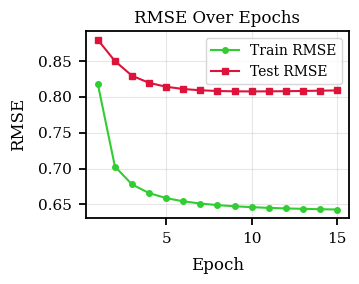


Finding polarizing movies...
Top 10 Most Polarizing IDs: [14387  9412  1835 16311 16306 16307 12199  2618 65003  7194]

Generating Recommendations (Tricks of the Trade)...
Top 10 Recs for LOTR fan:
Top 10 Recommendations for LOTR fan:
ID: 75744 (Score: 2.2319)
ID: 72996 (Score: 2.1288)
ID: 39387 (Score: 1.9538)
ID: 51890 (Score: 1.8671)
ID: 577 (Score: 1.8618)
ID: 14570 (Score: 1.8547)
ID: 60799 (Score: 1.8239)
ID: 56296 (Score: 1.8085)
ID: 20362 (Score: 1.7956)
ID: 21442 (Score: 1.7862)


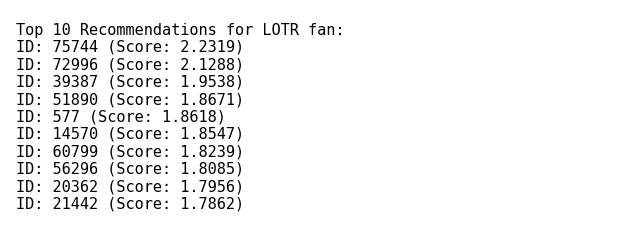

In [ ]:
new_width = 3.75
new_height = 3.0

fig, ax = plt.subplots()
ax.plot(range(1, epochs + 1), loss_list, marker='o', color='#4169E1', markersize=4)
ax.set_title("Training Loss Over Epochs")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (Neg Log Likelihood)")
plt.tight_layout()
plt.savefig("prac4_loss.pdf")
plt.show()

fig, ax = plt.subplots()
ax.plot(range(1, epochs + 1), train_rmse_list, marker='o', color='#32CD32', label="Train RMSE", markersize=4)
ax.plot(range(1, epochs + 1), test_rmse_list, marker='s', color='#DC143C', label="Test RMSE", markersize=4)
ax.set_title("RMSE Over Epochs")
ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE")
ax.legend(prop={'size': 10})
plt.tight_layout()
plt.savefig("prac4_rmse.pdf")
plt.show()

# --- Model analysis ---
print("\nFinding polarizing movies...")
item_norms = np.linalg.norm(item_factors, axis=1)
sorted_idx = np.argsort(item_norms)
print(f"Top 10 Most Polarizing IDs: {sorted_idx[::-1][:10]}")

# --- Dummy user recommendations ---
print("\nGenerating Recommendations (Tricks of the Trade)...")
dummy_ratings = [(4993, 5.0)]
d_bias = sum(lambda_prec * (r - item_biases[i]) for i, r in dummy_ratings) / (gamma_reg_bias + lambda_prec * len(dummy_ratings))
A, b = np.zeros((K, K)), np.zeros(K)
for i, r in dummy_ratings:
    v_i = item_factors[i]
    A += lambda_prec * np.outer(v_i, v_i)
    b += lambda_prec * (r - d_bias - item_biases[i]) * v_i
d_factor = np.linalg.solve(A + gamma_reg_factor * I, b)

movie_rating_counts = np.array([len(t) for t in train_by_movie])
scores = []
for i in range(num_movies):
    if movie_rating_counts[i] < 100: continue
    score = (d_factor @ item_factors[i]) + (0.05 * item_biases[i])
    scores.append((score, i))

scores.sort(key=lambda x: x[0], reverse=True)
print("Top 10 Recs for LOTR fan:")
rec_text = "Top 10 Recommendations for LOTR fan:\n" + \
           "\n".join(f"ID: {i} (Score: {s:.4f})" for s, i in scores[:10])
print(rec_text)

plt.figure(figsize=(6.5, 2.5))
plt.text(0.01, 0.5, rec_text, fontsize=11, family='monospace', va='center')
plt.axis('off')
plt.tight_layout()
plt.savefig("prac4_recommendations.pdf")
plt.show()
